# In which one geek helps other geeks to find more geeks.
*This is part 2 of a series of posts about a recommender system deployed as a web app. In [part 1] I scrape and fetch all the data that my app will rely on. In [part 3] I talk about actually implementing the app using the `web2py` framework and the `d3.js` library.*

[Boardgamegeek.com](https://boardgamegeek.com/) (BGG) is an online community for board game enthusiasts that provides social network features as well as a huge database of board games with ratings, comments, statistics, and other features of each game. Previously I wrote some [code to collect data on user ratings](http://sdsawtelle.github.io/blog/output/boardgamegeek-data-scraping.html) of games in the BGG database, now I'm going to take that raw data and build a recommender system, not for *games*, but for *friends*! I'll be using the neighborhood approach, where the ratings reveal neighborhoods of similar users: for a given user, I want to measure similarity to second-degree connections in their social graph, as well as identify users in the population at large who are particularly similar to them. 

I wrote a brief intro to recommender systems [here](http://sdsawtelle.github.io/blog/output/week9-recommender-andrew-ng-machine-learning-with-python.html) for Andrew Ng's ML homework on the same, if you want a bit of quick background.

>## Tools Covered:
- pandas `corr` method for a cythonized Pearson Correlation
- stats `binned_statistic` for some very versatile binning + aggregating
- `sqlite3` for interacting with local SQLite databases via python

In [8]:
import requests
from bs4 import BeautifulSoup
import scipy.io
import matplotlib.pyplot as plt
import matplotlib 
import pandas as pd
import numpy as np
import pickle
from time import sleep
import sqlite3
import timeit
import random 
from scipy import stats
from sklearn.metrics import mean_squared_error

import snips as snp  # my snippets
snp.prettyplot(matplotlib)  # my aesthetic preferences for plotting
%matplotlib inline

# Discard Users with Few Ratings
For building a recommender system we'll want to restrict to only users who rated a reasonable fraction of the games under consideration. This will help keep our database size manageable without much loss of information: someone who has rated only an infinitesimal fraction of games is not likely to have much overlap of rated games with the average user, meaning we won't be able to compute a similarity metric that we have any confidence in.

In [212]:
# Make a connection to the database housing ratings. 
connex = sqlite3.connect("bgg_ratings_recommender.db")  # Opens file if exists, else creates file
cur = connex.cursor()  # This object lets us actually send messages to our DB and receive results

# Retrieve usernames for all users with < 20 ratings in the DB
sql = " ".join((
    "SELECT username",
    "FROM (SELECT username, count(*) as freqn FROM data GROUP BY username)",
    "AS tbl WHERE freqn < 20",
))
users = pd.read_sql_query(sql, connex)
users.sample(n=3)

,username
58262,eng621
88013,stevedoetsch
62818,hanss


In [213]:
# Drop all the rows for the above list of users
usrs = ["'" + usr + "'" for usr in users["username"].values]
str_matching = "(" + ",".join(usrs) + ")"  # Construct the string of SQL language
sql = "DELETE FROM data WHERE username IN " + str_matching + ";"
cur.execute(sql)

# Close DB connection
connex.commit()
connex.close()

Let's load the full data set into RAM and calculate the sparsity of this ratings data. If every user in our toy set rated every movie in our toy data we'd have a sparsity of 100%. Instead we have:

In [77]:
# Load full data set into RAM
connex = sqlite3.connect("bgg_ratings_recommender.db")  # Opens file if exists, else creates file
sql = "SELECT * FROM data"
df = pd.read_sql_query(sql, connex)
connex.close()

In [78]:
len(df)

8747507

In [79]:
df.drop_duplicates(inplace=True)
len(df)

8473814

In [216]:
# Calculate sparsity of ratings data
max_n_ratings = len(df["gameid"].unique())*len(df["username"].unique())
actual_n_ratings = len(df)
print("Sparsity of Ratings Data is %.2f%%" % (100*actual_n_ratings/max_n_ratings))

Sparsity of Ratings Data is 1.13%


Finally, lets set the usernames as a new index for this database, since that's how we'll be mostly pulling from it (this makes the database read operations faster). 

In [220]:
# Make a connection to a new database, write to it, then close
connex = sqlite3.connect("bgg_ratings_recommender.db") 
cur = connex.cursor()
sql = "CREATE INDEX usr_idx ON data (username);"
cur.execute(sql)
connex.commit()
connex.close()

## Some Users Rated a Game More than Once!
This is an unfortunate complication - some users "updated" their rating of a game so that in our database we have multiple (usually 2) entries for that specific (game, user) pairing which have different ratings values. Since the ratings are not timestamped we have no way of knowing which is the more recent value so our choices are to drop the ratings or average them. Let's inspect an example to get a sense for whether the two ratings disagree a lot or just a little. 

In [80]:
gameid = 17226
cnts = df.loc[df["gameid"]==gameid, 
              ["username", "ratings"]].groupby("username").count()  # Num. of entries for this game for each user

In [81]:
multi_users = cnts[cnts["ratings"] > 1].index  # list of usernames who rated the game more than once
multis = df[(df["gameid"]==gameid) & (df["username"].isin(multi_users))].sort_values(by="username")
stds = multis.groupby("username")["ratings"].std()  # standard deviation of ratings for users with multiple entries
stds

username
Agzaroth          1.060660
Egberth2          0.707107
Francescopela     0.494975
Indy81            0.707107
Khelz             0.707107
Pablarian         0.141421
Psymon            0.707107
Shavyer           0.707107
The Reaper        0.353553
bittykitty        1.060660
familywontplay    0.141421
leoleez           0.353553
lionandlamb       0.707107
magedelanuit      0.353553
murks666          0.707107
nareau            0.707107
omega0079         0.707107
skullgicien       0.707107
tugurio77         0.707107
utoption2         0.707107
xmixahlx          0.707107
Name: ratings, dtype: float64

This tells us that when users give multiple ratings they don't typically differ all that much. In this case we can be comfortable replacing the multiple entries with a single entry having the average rating. Let's do this one time with the full data set and then update the data base.

In [89]:
multis = df.loc[df.duplicated(subset=["gameid", "username"], keep=False)]  # rows where (game, user) is duplicate
df_no_multis = df.loc[~df.duplicated(subset=["gameid", "username"], keep=False)] # rows where (game, user) is NOT duplicate

In [90]:
len(multis)  # Just out of curiosity, how often do users re-rate a game?

28423

In [91]:
means = multis.groupby(["gameid", "username"])["ratings"].mean().reset_index()  # replace each set of duplicates with avg
means.head()

,gameid,username,ratings
0,1,Celtic,8.75
1,1,Iago71,8.25
2,1,Morganza,8.05
3,1,Oramon,9.50
4,1,PaulinTheLion,7.50


In [92]:
df = pd.concat([df_no_multis, means])  # Add the de-duplicated average rows back in
any(df[["username", "gameid"]].duplicated())  # Verify that we successfully completely deduplicated

False

In [98]:
# Write the updated values to a new database
connex = sqlite3.connect("bgg_ratings_recommender_deduplicated.db") 
df.to_sql("data", connex, index=False)
connex.commit()
connex.close()

# Neighborhood Methods for User Similarity
In *Neighborhood* methods of recommender systems the ratings reveal neighborhoods of similar games or similar users. For instance, the neighbors of a particular game $b_j$ will be other games to which users tended to give a similar rating as they gave to $m_j$. If most users who rated both *Chess* and *Go* tended to rate them similarly, then those games are close neighbors and someone who liked one will probably like the other. Likewise, two users are neighbors if, for games that they have both rated, their ratings tend to agree, and if your close neighbor liked a game, you probably would too. In this case my recommender system is recommending *other users* who would be good buddies, not new games that the user might enjoy, so I will just be looking at user-user similarity metrics. **But how can you validate a user-similarity algorithm... what is the ground truth?** My approach will be to use a downstream metric - how well we can predict ratings using a k-nearest neighbors voting approach, where neighbors are decided from the similarity metric!

## Standardizing Data For Correlation Metrics
Intuitively we think users are similar if they tend to both rate the same game as *higher than what they rate games on average*, not just that they both rate the game "highly". If two users have given the same five games the highest ratings of all games they have rated then they are VERY similar, even if one of them is a softy who never gives below three stars and one of them is a harsh critic who never gives five stars. For this reason we start by "centering" the ratings for each user so that they reflect *relative preference* - distance of the rating from that user's average rating. By the same logic we can also standardize to remove the effect of different ratings variance for different users. This is called Z-Score normalization and it is somewhat less used. 

If the rating given to the $i^{th}$ movie by the $u^{th}$ user is $r_{ui}$, and this user's ratings have a mean $\bar{r}_u$ and standard deviation $\sigma_u$, then these mappings are:

\begin{align*}
\textrm{Mean-Centering:} \qquad r_{ui} \rightarrow r_{ui}-\bar{r}_u\\
\textrm{Z-Score Normalization:} \qquad r_{ui} \rightarrow \frac{r_{ui}-\bar{r}_u}{\sigma_u}
\end{align*}

## Cosine Similarity and Pearson Correlation
The simplest implementation of similarity between two users is the Cosine Similarity. This begins by representing each user as a vector, $\mathbf{r}$, in "game space" whose components are simply the raw ratings they gave to each game. The first objection is what to do with missing ratings - it would be inappropriate to just replace them with some number as that would be equivalent to planting false information. For this reason **similarity between two users is always computed in a the subspace of games that were rated by *both* users, and the cosine similarity is just the angle between two users (vectors) in this space.** If we let $I_{a}$ be the set of games rated by user $a$, likewise for $I_b$, and $I_{ab}$ is the set of games rated by *both* users, then

\begin{align*}
\textrm{Unstandardized cosine similarity of users $a$ and $b$:} \qquad CV(a,b) = \frac{\mathbf{r}_a^T\mathbf{r}_b}{||\mathbf{r}_a||||\mathbf{r}_b||} = \frac{\sum_{i \in I_{ab}} r_{ai}r_{bi}}{\sqrt{\sum_{i \in I_{ab}} r_{ai}^2}\sqrt{\sum_{i \in I_{ab}} r_{bi}^2}}
\end{align*}

Since we believe the mean-centered or z-score normalized ratings to reflect a truer comparison between two users, you could instead plug those into the cosine similarity, rather than the raw ratings. **The Pearson correlation, a very popular metric for similarity, is just the cosine similarity using mean-centered ratings and, as usual, taken in the subspace of movies that *both* users rated:**

\begin{align*}
\textrm{Pearson correlation of users $a$ and $b$:} \qquad PC(a,b) = \frac{\sum_{i \in I_{ab}} (r_{ai}-\bar{r}_a)(r_{bi}-\bar{r}_b)}{\sqrt{\sum_{i \in I_{ab}} (r_{ai}-\bar{r}_a)^2}\sqrt{\sum_{i \in I_{ab}} (r_{bi}-\bar{r}_b)^2}}
\end{align*}

Centering for Pearson Correlation is usually done by using the average rating over all movies that a user has rated, *not* just movies that both users have rated (which would be throwing away information). This is computationally cheaper since the centering can be done just once for each user.  

### Discounted Pearson Correlation for Uncertainty
Another piece of information that we might want to fold into a similarity metric is how confident we are in the correlation we computed. If two users have a large number of games that they have both rated then we can be more confident in our assessment than if they only overlap on a handful of games. A common way to deal with this is to set a threshold $\beta$ for the number of common ratings, below which we impose a penalty that decreases the similarity linearly with the number of shared ratings:


\begin{align*}
\textrm{Uncertainty-Discounted Pearson correlation of users $a$ and $b$:} \qquad DPC(a,b) = PC(a,b) \times \frac{\min{\bigl\{|I_{ab}|,\beta\bigr\}}}{\beta} 
\end{align*}

### Weighted Pearson Correlation
A neat insight into how a human might go about qualitatively judging similiarity is that if a game is universally liked or hated, then for two users to agree on their rating of it doesn't actually tell us much. Comparing two users feelings on a game that has a large variance in its ratings would be more informative. On the other hand, if there is universal concensus on a game but two users both agree on a rating very *different from the concensus* then that also may contain useful information. The weighted Pearson Correlation attempts to capture these effect by weighting each term in the "dot product" by $\lambda_i$. 

In several sources this is achieved by a weight analagous to the inverse document frequency in information retrieval: $\lambda_i= \log\frac{|I_i|}{|I|}$, where $|I_i|$ is the number of users who rated item $i$ and $|I|$ is the total number of users. However it's not clear how this achieves the desired effect. An alternative weighting that makes more sense would be the variance of ratings of item$i$, $\lambda_i = \textrm{Var}(r_i)$. However, as discussed [here](https://www.cs.purdue.edu/homes/lsi/sigir04-cf-weight.pdf) an interesting complication is that a large variance in ratings for a game might instead reflect the fact that it is difficult for users to rate, or users have confused feelings about evaluating this game, which would indicate that *less* weight should be placed on ratings of the item.


\begin{align*}
\textrm{Weighted Pearson correlation of users $a$ and $b$:} \qquad WPC(a,b) = \frac{\sum_{i \in I_{ab}} \lambda_i(r_{ai}-\bar{r}_a)(r_{bi}-\bar{r}_b)}{\sqrt{\sum_{i \in I_a} \lambda_i(r_{ai}-\bar{r}_a)^2}\sqrt{\sum_{i \in I_b} \lambda_i(r_{bi}-\bar{r}_b)^2}}
\end{align*}


## Making Predictions Using Similarities
Once you've decided on a metric of similarity you need to use that metric to actually make predictions about the rating a user would give a game. This proceeds as follows, for the game of interest, only include users who have given a rating to that game. Now rank those users in terms of similarity using your chosen metric, and identify the $k$-nearest neighbors for the user. The idea is that the users rating of this movie will be similar to his neighbors rating of this movie. 

A common estimator for a user's rating is the average of his neighbors ratings - remember though, we're still working with the centered versions of the ratings so the actual estimator "uncenters" as a last step. This average of the neighbors ratings can include some weighting that lets neighbors with higher correlation to the user affect the average more strongly, a common weighting is some power, $\alpha$, of the similarity metric $\textrm{sim}(a,b)$:

\begin{align*}
\textrm{Weighted Average of Neighbors Ratings:} \qquad \hat{r_{ai}} = \bar{r}_{ai} + \sum_{b\in K} (r_{bi}-\bar{r}_{bi})\times\frac{\textrm{sim}(a,b)^\alpha}{\sum_{b\in K} \textrm{sim}(a,b)^\alpha}
\end{align*}

### Resources
- a [book chapter on neighborhood based](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=0ahUKEwjn69O5-fbRAhUC7oMKHTGRBxwQFgghMAA&url=http%3A%2F%2Fwww.springer.com%2Fcda%2Fcontent%2Fdocument%2Fcda_downloaddocument%2F9783319296579-c1.pdf%3FSGWID%3D0-0-45-1554478-p179516130&usg=AFQjCNFguPIKO_MkGC3BBfrERZ5hc3hJDQ&sig2=xxmysCPmXsqBXkC-zkZihQ) methods in a recommender system textbook
- A [comprehensive survey of neighborhood methods](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=0ahUKEwiHnOKXj_fRAhWBXiYKHYoJBVwQFgggMAA&url=http%3A%2F%2Fglaros.dtc.umn.edu%2Fgkhome%2Ffetch%2Fpapers%2FNbrRSsurvey2011.pdf&usg=AFQjCNH3eLtm_XHHfzniZmX0m17fuULmpg&sig2=ak_P-UOW-bk7TqxQNacRTQ)
- paper [evaluating different collaborative filtering algorithms](https://ai2-s2-pdfs.s3.amazonaws.com/0fcc/45600283abca12ea2f422e3fb2575f4c7fc0.pdf) performance on several datasets
- stackexchange answers about Pearson Correlation vs. Spearman Rank [here](http://stats.stackexchange.com/questions/3730/pearsons-or-spearmans-correlation-with-non-normal-data) and [here](http://stats.stackexchange.com/questions/8071/how-to-choose-between-pearson-and-spearman-correlation).
- [informatics course notes](http://www.inf.ed.ac.uk/teaching/courses/inf2b/learnnotes/inf2b-learn-note02-2up.pdf) on similarity metrics
- [comprehensive overview of recommender systems](https://arxiv.org/pdf/1202.1112.pdf) on ArXiv

# Example Comparison of Metrics
Let's build a set of fake users to see the effect of centering and dropping missing ratings versus filling them with zero. Here are the users:
- Bob0 who has an average rating of 6 and a reasonably large variance in ratings
- Bob1 who has the exact same *relative preferences* as Bob0, but has a diferent average rating
- Bob2 who has the exact same *relative preferences* as Bob0, but has a different standard deviation of ratings
- Bob3 who has the exact same *relative preferences* as Bob0, but is missing some data
- Bob4 who has the exact same *relative preferences* as Bob0, but has a different average and standard deviation.
- Bob5 who has the exact opposite *relative preferences* as Bob0.


We probably want a metric that returns a very high correlation between Bob0 and all of these users since they all have the same relative preferences.

In [192]:
Bob0 = np.array([2, 3, 3, 5, 6, 6, 6, 7, 9, 9, 10])
Bob1 = Bob0 - 2
Bob2 = np.mean(Bob0) + 0.4*(Bob0 - np.mean(Bob0))
Bob3 = np.array([2, np.nan, 3, 5, 6, 6, 6, np.nan, 9, np.nan, 10])
Bob4 = Bob2 + 2
Bob5 = Bob0[::-1]

bobs = pd.DataFrame([Bob0, Bob1, Bob2, Bob3, Bob4, Bob5], 
                    index=["Bob0", "Bob1_shifted", "Bob2_squeezed", 
                           "Bob3_missing", "Bob4_squeezed_shifted", "Bob5_anticorrelated"])
bobs

,0,1,2,3,4,5,6,7,8,9,10
Bob0,2.0,3.0,3.0,5.0,6,6,6,7.0,9.0,9.0,10.0
Bob1_shifted,0.0,1.0,1.0,3.0,4,4,4,5.0,7.0,7.0,8.0
Bob2_squeezed,4.4,4.8,4.8,5.6,6,6,6,6.4,7.2,7.2,7.6
Bob3_missing,2.0,NaN,3.0,5.0,6,6,6,NaN,9.0,NaN,10.0
Bob4_squeezed_shifted,6.4,6.8,6.8,7.6,8,8,8,8.4,9.2,9.2,9.6
Bob5_anticorrelated,10.0,9.0,9.0,7.0,6,6,6,5.0,3.0,3.0,2.0


In [204]:
def cosine_nan_to_zero(x, bob):
    """Fill NaNs with zero then compute angle. DON'T DO THIS!! """
    x = np.array(x)
    x = np.nan_to_num(x)
    return (np.dot(bob,x)/(np.linalg.norm(bob)*np.linalg.norm(x)))

def cosine_sim(x, bob):
    """Drop movies with any NaNs then compute angle"""
    x = np.array(x)
    bob = bob[~np.isnan(x)]
    x = x[~np.isnan(x)]
    return (np.dot(bob,x)/(np.linalg.norm(bob)*np.linalg.norm(x)))

def pearson_corr(x, bob):
    """Mean-center then drop movies with any NaNs and compute angle"""
    x = np.array(x)
    bob = bob - np.mean(bob)
    x = x - np.nanmean(x)
    bob = bob[~np.isnan(x)]
    x = x[~np.isnan(x)]
    return (np.dot(bob,x)/(np.linalg.norm(bob)*np.linalg.norm(x)))

def mean_sqrd_diff(x, bob):
    x = np.array(x)
    bob = (bob - np.mean(bob))/np.nanstd(bob)
    x = (x - np.nanmean(x))/np.nanstd(x)
    bob = bob[~np.isnan(x)]
    x = x[~np.isnan(x)]
    return len(x)/(np.sum(np.linalg.norm(x-bob))+0.1)

In [205]:
results = pd.DataFrame()
results["Cosine Fill Nan with 0 (DON'T DO THIS!)"] = bobs.apply(cosine_nan_to_zero, args=(Bob0,), axis=1)
results["Cosine Drop NaN"] = bobs.apply(cosine_sim, args=(Bob0,), axis=1)
results["Pearson"] = bobs.apply(pearson_corr, args=(Bob0,), axis=1)
results["Mean Squared Diff"] = bobs.apply(mean_sqrd_diff, args=(Bob0,), axis=1)

results

,Cosine Fill Nan with 0 (DON'T DO THIS!),Cosine Drop NaN,Pearson,Mean Squared Diff
Bob0,1.000000,1.000000,1.000000,110.000000
Bob1_shifted,0.986475,0.986475,1.000000,110.000000
Bob2_squeezed,0.973350,0.973350,1.000000,110.000000
Bob3_missing,0.837685,1.000000,0.998774,33.311656
Bob4_squeezed_shifted,0.963093,0.963093,1.000000,110.000000
Bob5_anticorrelated,0.699571,0.699571,-1.000000,1.633684


# Implementing Basic Pearson Correlation (in Pandas!)
To compute the Pearson correlation (PC) we can start by transforming each user vector by centering (subtract the average rating) and normalizing (divide by the length). Then the PC will just be literally the dot product between two users.

In [2]:
connex = sqlite3.connect("bgg_ratings_recommender_deduplicated.db")  # Opens file if exists, else creates file
sql = "SELECT * FROM data"
df = pd.read_sql_query(sql, connex)
connex.close()

In [3]:
df.head()

,gameid,username,ratings
0,181304,Kylepjams,10
1,181304,gabrielperin,10
2,181304,marisahill,10
3,181304,Unsub001,10
4,181304,Telaire,10


To compute similarity we want to transform the dataframe into an $n_{users}\times n_{games}$ matrix $R$, where the $R_{ij}$ is the rating that user $j$ gave to game $i$. This is a classic pivot, but unfortunately pivoting 8.7 million rows is beyond the scope of my hardware (source: it totally froze my computer). Instead we'll have to try an approach that involves chunking up the ratings. So let's recap what we need:

- An algorithm that lets us make a prediction for the rating given to game $j$ by user $i$. This involves finding, among all the users who rated game $j$, the $k$ of them that are most similar to user $i$. 
- Run this algorithm on, at minimum, a large random subset of the data
- Allow for splitting into train/test sets in order to fit possible parameters of the similarity metric

A possible approach is as follows:
- loop through games (13000) and for each game pull all the ratings from all the users who rated that game
- for each such user, run the algorithm to make a prediction for that user on that game by computing similarity against all the other users who rated the game

To start, lets take an example game with a decent number of ratings and pretend we are interested in predicting some user ratings for this game in the approach described above. What will the distribution of correlations and number of common games look like among the users who rated our example game?

In [5]:
gameid = 2516
users = df.loc[df["gameid"] == gameid, "username"].values  # list of all users who rated this game
df_sample = df[df["username"].isin(users)]  # all ratings for all games from users who rated this game
df_pivot = df_sample.pivot_table(index="username", columns="gameid", values="ratings")  # pivot to matrix (user x game) matrix
df_pivot.head()

gameid,1,2,3,4,5,7,8,9,10,11,...,206547,206940,206941,206944,207336,207591,207691,209010,209357,212445
username,,,,,,,,,,,,,,,,,,,,,
1374Phantom,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7rich7,NaN,NaN,7,NaN,6,NaN,NaN,NaN,7.4,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99trev,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AHShole,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Aceldamor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Computing Correlations Between Users (in Pandas!)
Now unfortunately the Pearson correlation cannot be easily matricized because, for any pair of users, the normalization should involve only the ratings that those two users have in common. The only way to approach this is looping through the user pairs. Luckily pandas has a built in function that is all cythonized and whatnot! If you check the source for this on github ([source for pandas.algos.nancorr](https://github.com/pandas-dev/pandas/blob/master/pandas/algos.pyx)) then you can see that the implementation is to drop all variables not in common between two users, then compute a mean for each user based on this restricted number of ratings and center the data, and then compute the correlation dividing by the norms of each user based on this restricted number of ratings. There is even a kwarg `min_periods` that lets you set a threshold for the number of variables in common, below which the correlation will return 0 (the default is at least 2 variables in common). Note that `DataFrame.corr` will compute pairwise correlations between the *columns* of your dataframe, so in our case we first transpose our frame.

In [7]:
%%time
temp = df_pivot.transpose()
corrs = temp.corr()  # Default for min_periods is 1

Wall time: 3.3 s


In [8]:
corrs.head()

username,1374Phantom,7rich7,99trev,AHShole,Aceldamor,AcikCieslik,Akhorahil,Alienated One,Almalik,Alyksandyr,...,woodoo03,xKoBiEx,xlorp,yacoba1995,ynnen,yosemite,youperguy,zakspeed,zarathud,ztilleto
username,,,,,,,,,,,,,,,,,,,,,
1374Phantom,1.000000,-0.091145,0.618590,0.364047,0.381661,-0.192450,0.760726,-0.301511,-1.000000,0.500000,...,NaN,-0.005291,-0.654654,0.852327,0.827379,0.000000,-0.044194,-1.000000,0.488901,-1.000000
7rich7,-0.091145,1.000000,0.094221,0.115282,0.658232,0.142912,0.433924,0.155454,-0.207401,0.173426,...,0.016452,0.334053,0.506072,-0.330118,0.071530,0.396073,0.133600,0.440817,0.086835,0.154681
99trev,0.618590,0.094221,1.000000,0.604691,-0.156813,0.178173,0.114022,-0.173205,0.426401,0.479463,...,0.496255,0.497769,0.452393,0.131559,-0.017099,0.188982,-0.448276,0.577843,0.407294,0.866025
AHShole,0.364047,0.115282,0.604691,1.000000,-0.105409,-0.023901,0.209371,0.209466,0.735307,0.265556,...,-0.028478,0.482972,0.231749,0.359948,0.097465,0.260985,-0.080680,0.364519,0.300436,-0.151311
Aceldamor,0.381661,0.658232,-0.156813,-0.105409,1.000000,0.523205,0.840027,-0.500000,-1.000000,0.301511,...,0.518875,-0.462250,-0.040032,NaN,0.609397,1.000000,0.572078,0.243975,0.058824,NaN


Ok that took a little while *but* we now are in a position to identify the top $k$ nearest neighbors for each of these users! First lets take a look at the values for this Pearson Correlation computation. Interestingly the correlations are not centered around zero and the distribution is not quite symmetric.

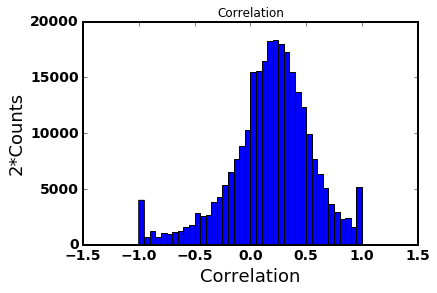

In [9]:
# Look at just the upper triangular submatrix (excluding the diagonal)since matrix is symmetric.
Xcorr = corrs.as_matrix()
np.fill_diagonal(Xcorr, np.nan)

fig, ax = plt.subplots()
snp.labs("Correlation", "2*Counts", "Correlation")
trash = ax.hist(Xcorr[~np.isnan(Xcorr)], bins=40)

# Exploratory Analysis of Correlations

## Number of Rated Games in Common
Lets also investigate how many rated games each user pair has in common. We can see that most users have less than 10 games in common, not so good for feeling confident in our calculations. 

In [12]:
X = df_pivot.as_matrix()  # get values as a numpy matrix

# Make a matrix holding number of common games rated between users (i, j)
m1 = (~np.isnan(X)).astype(np.float64)  # zeroes for missing ratings, one elsewhere
shared = np.dot(m1, m1.T)
np.fill_diagonal(shared, np.nan)  # diagonals are matching a user with themselves so don't include!

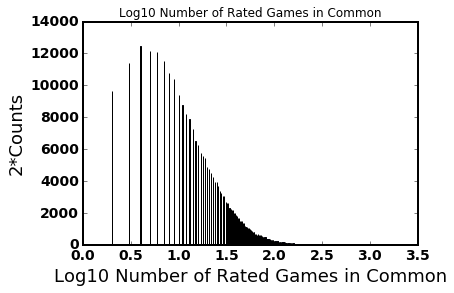

In [13]:
# Plot the distribution of number of rated games in common between users
fig, ax = plt.subplots()
snp.labs("Log10 Number of Rated Games in Common", "2*Counts", "Log10 Number of Rated Games in Common")
trash = ax.hist(np.log10(shared[~np.isnan(shared)]), bins=2500)

## Relationship Between Correlation and Number of Games in Common
How does the distribution of our computed correlations change as a function of the number of games-in-common that it is computed on? Let's look at a scatterplot of correlations against number of shared games:

In [14]:
# Grab just the upper triangle (above the diagonal) to avoid duplicating scatter points
trngl_count = np.triu(shared, k=1)
trngl_corr = np.triu(Xcorr, k=1)

mask = trngl_count > 1
trngl_cnt = trngl_count[mask]
trngl_cor = trngl_corr[mask]

(-1, 2000)

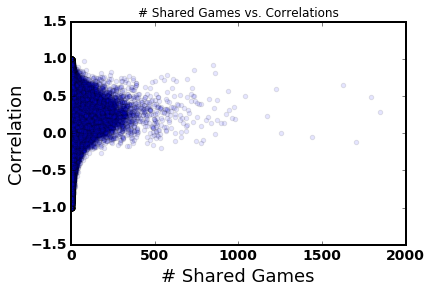

In [15]:
fig, ax = plt.subplots()
snp.labs("# Shared Games", "Correlation", "# Shared Games vs. Correlations")
ax.scatter(trngl_cnt, trngl_cor, alpha=0.1)
ax.set_xlim([-1, 2000])
ax.axhline(y=0, color="red")

(-1, 200)

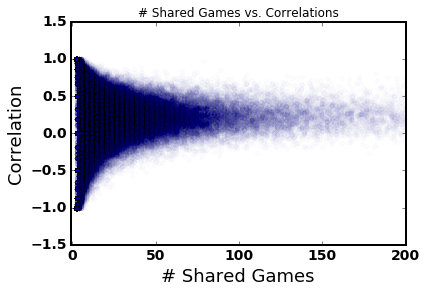

In [16]:
fig, ax = plt.subplots()
snp.labs("# Shared Games", "Correlation", "# Shared Games vs. Correlations")
ax.scatter(trngl_cnt, trngl_cor, alpha=0.01)
ax.set_xlim([-1, 200])
ax.axhline(y=0, color="red")

Since there are *sooooo* many points in the lower range of the number of shared games it's hard to get a feel for what the distribution of correlations is doing, so lets make a more illuminating plot that bins the points by number of shared games.

In [37]:
# Bin the data points by number of shared games and compute mean/var in each bin
binned_means = stats.binned_statistic(trngl_cnt[trngl_cnt < 150], trngl_cor[trngl_cnt < 150], statistic='mean', bins=100)
binned_stds = stats.binned_statistic(trngl_cnt[trngl_cnt < 150], trngl_cor[trngl_cnt < 150], statistic='std', bins=100)

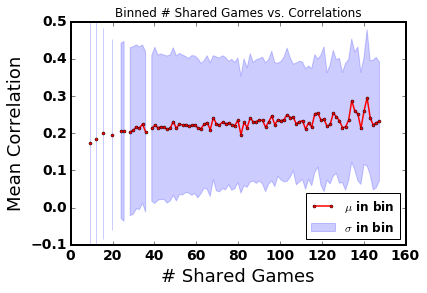

In [40]:
fig, ax = plt.subplots()
snp.labs("# Shared Games", "Mean Correlation", "Binned # Shared Games vs. Correlations")
ax.plot(binned_means[1][:-1], binned_means[0], color="r", label="$\mu$ in bin")
upper = binned_means[0] + binned_stds[0]
lower = binned_means[0] - binned_stds[0]
plt.fill_between(binned_means[1][:-1], lower, upper, color='b', alpha=0.2, label="$\sigma$ in bin")
ax.set_ylim([-0.1, 0.5])
ax.legend(loc="lower right")

There is a small effect that the fewer number of shared games between two users, the lower their correlation skews. That is, the distribution of correlations for user pairs with only a few rated games in common has a much lower mean and wider variance than the distribution of correlations for user pairs with a lot of games in common. Is this because when two users have rated a lot of the same games that implies that they have somewhat similar tastes in that they are choosing to play the same games? Or is it that to have a lot of games in common implies you have rated a very large number of games, and only a certain type of person does this (meaning all people who have rated a huge number of games are somewht similar).

**Overall the mean correlation is positive. This might reflect the fact that there are a few universally liked games with a very large number of ratings that are driving a lot of the correlation due to the lower overall sparsity of the data.** 

## Analysis of a Random Sample of Users
What about repeating this with a random sample of 500 users.

In [3]:
# Get random sample of users
users = pd.read_csv("bgg_users.csv", header=None)
users = users[0].sample(n=3000).values
users = list(set(users))

# Pull all the rows for the users in the random sample
connex = sqlite3.connect("bgg_ratings_recommender_deduplicated.db")  # Opens file if exists, else creates file
usrs = ["'" + usr + "'" for usr in users]
str_matching = "(" + ",".join(usrs) + ")"  # Construct the string of SQL language
sql = "SELECT * FROM data WHERE username IN " + str_matching + ";"
df_sample = pd.read_sql_query(sql, connex)
connex.close()

# Create the matrix of users vs. games
df_pivot = df_sample.pivot_table(index="username", columns="gameid", values="ratings")  # pivot to matrix (user x game) matrix

In [4]:
%%time
# Compute correlations
temp = df_pivot.transpose()
corrs = temp.corr()
temp = df_pivot.transpose()
corrs = temp.corr()
Xcorr = corrs.as_matrix()

Wall time: 37.3 s


In [5]:
# Make a matrix holding number of common games rated between users (i, j)
X = df_pivot.as_matrix()  # get values as a numpy matrix
m1 = (~np.isnan(X)).astype(np.float64)  # zeroes for missing ratings, one elsewhere
shared = np.dot(m1, m1.T)
np.fill_diagonal(shared, np.nan)  # diagonals are matching a user with themselves so don't include!

In [14]:
# Grab just the upper triangle (above the diagonal) to avoid duplicating scatter points
trngl_count = np.triu(shared, k=1)
trngl_corr = np.triu(Xcorr, k=1)
mask = (trngl_count > 1) & ~np.isnan(trngl_corr)
trngl_cnt = trngl_count[mask]
trngl_cor = trngl_corr[mask]

In [17]:
# Bin the data points by number of shared games and compute mean/var in each bin
binned_means = stats.binned_statistic(trngl_cnt[trngl_cnt < 150], trngl_cor[trngl_cnt < 150], statistic='mean', bins=150)
binned_stds = stats.binned_statistic(trngl_cnt[trngl_cnt < 150], trngl_cor[trngl_cnt < 150], statistic='std', bins=150)

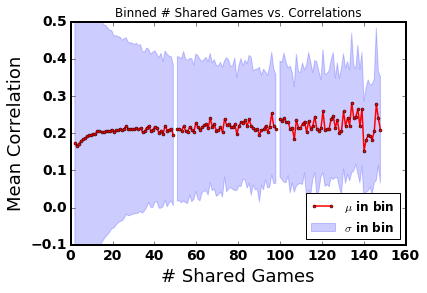

In [18]:
fig, ax = plt.subplots()
snp.labs("# Shared Games", "Mean Correlation", "Binned # Shared Games vs. Correlations")
ax.plot(binned_means[1][:-1], binned_means[0], color="r", label="$\mu$ in bin")
upper = binned_means[0] + binned_stds[0]
lower = binned_means[0] - binned_stds[0]
plt.fill_between(binned_means[1][:-1], lower, upper, color='b', alpha=0.2, label="$\sigma$ in bin")
ax.set_ylim([-0.1, 0.5])
ax.legend(loc="lower right")

With a random selection of users we still see the mean correlation at around 0.2 and the same slight slight trend towards higher average correlation with increasing number of shared games. 

## How Many Shared Games Needed for Confidence?
A reasonable interpretation of the previous plot is that the number of shared games beyond which we can have very strong confidence is the number past which the standard deviation of the correlations stays roughly the same. We can see that staring from very few shared games the variance funnels in: it funnels quickly before 30 games and flattens out around 70 shared games. In terms of the weighted Pearson Correlation, we might set our $\beta = 30$.

Another way we might investigate a reasonable value of $\beta$ is to take a closer look at user pairs with a lot of overlap such that we have a lot of confidence in the computed correlation. Lets do an experiment where we take a (user, user) pair with > 200 games rated in common and we assume that the correlation computed between these two is approximately their true similarity. Then we randomly chunk up their shared games into chunks of size $n$ and see what the distribution of error in the correlations computed from these chunks looks like as a function of $n$. Error means difference between the true similarity (correlation computed on all common games) and the estimate of similarity (computed on just a chunk of size $n$). If we repeat this with a large number of users we will get an even better sense of the effect of chunk size.

In [50]:
# Restrict to user pairs with high number of shared games
highcnts = np.transpose(np.nonzero(trngl_count > 150))

In [51]:
# Example of getting a particular user pair with high number of shared games
x = highcnts[0][0]
y = highcnts[0][1]
x, y, shared[x, y], Xcorr[x, y]

(12, 61, 162.0, 0.37787388237828401)

In [60]:
# Example of computing correlation between two users
paircorr = Xcorr[x,y]
user1, user2 = X[x], X[y]
mask = (~np.isnan(user1)) & (~np.isnan(user2))
user1, user2 = user1[mask], user2[mask]
pd.algos.nancorr(np.column_stack([user1, user2]))[0, 1]  # Same machinery as used by DataFrame.corr()

0.19654207398765611

In [78]:
# For different chunk sizes, compute correlation on those chunks and save the errors
errors = []
sizes = []
for loc in highcnts:
    x = loc[0]
    y = loc[1]
    # Get the ratings for these two users on the games they have in common, randomize!
    paircorr = Xcorr[x,y]
    user1, user2 = X[x], X[y]
    mask = (~np.isnan(user1)) & (~np.isnan(user2))
    user1, user2 = user1[mask], user2[mask]
    for n in np.arange(2, 75, 20):
        combo = list(zip(user1, user2))
        random.shuffle(combo)
        for chunk in snp.chunks(combo, n):
            us1 = [rat1 for rat1, rat2 in chunk]
            us2 = [rat2 for rat1, rat2 in chunk]
            corr = pd.algos.nancorr(np.column_stack([us1, us2]))[0, 1]
            errors.append(paircorr - corr)
            sizes.append(len(us1))

In [79]:
# Bin the data points by number of shared games and compute mean/var in each bin
sizes = np.array(sizes)
errors = np.array(errors)
binned_means = stats.binned_statistic(sizes, errors, statistic='mean', bins=20)
binned_stds = stats.binned_statistic(sizes, errors, statistic='std', bins=20)
bin_centers = (binned_means[1][1:] - binned_means[1][:-1])/2 + binned_means[1][:-1]

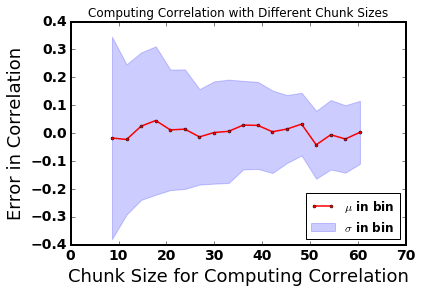

In [80]:
# Plot Correlation Errors vs. Chunk Size of Correlation Estimator
fig, ax = plt.subplots()
snp.labs("Chunk Size for Computing Correlation", "Error in Correlation", "Computing Correlation with Different Chunk Sizes")
ax.plot(bin_centers, binned_means[0], color="r", label="$\mu$ in bin")
upper = binned_means[0] + binned_stds[0]
lower = binned_means[0] - binned_stds[0]
plt.fill_between(bin_centers, lower, upper, color='b', alpha=0.2, label="$\sigma$ in bin")
ax.legend(loc="lower right")

This is a very helpful result. We see a clear improvement in the variance of the estimator (correlation computed from a chunk subset of shared ratings) for true correlation (correlation computed from all the shared ratings) as the chunk size of our estimator increases. The improvement is most dramatic below a chunk size of 30, which again might suggest a reasonable value is $\beta = 30$. 

# Implementing Nearest Neighbors Prediction
OK, now we have the Pearson Correlation calculation up and running and we have a good sense of what these values will look like, especially as a function of number of shared games (this also gave us an idea for reasonable $\beta$ values when we later implement a Pearson Correlation with uncertainty). 

Recall that our PC machinery results in a dataframe holding pairwise correlations between all the users in the original frame. For our purposes let's return to the example of pulling all the users who rated a particular game, and let's go ahead and require a minimum of 4 shared ratings to compute a correlation (otherwise fill in with NaN):

In [128]:
gameid = 2516
users = df.loc[df["gameid"] == gameid, "username"].values  # list of all users who rated this game
df_sample = df[df["username"].isin(users)]  # all ratings for all games from users who rated this game
df_pivot = df_sample.pivot_table(index="username", columns="gameid", values="ratings")  # pivot to matrix (user x game) matrix
df_pivot.head()

gameid,1,2,3,4,5,7,8,9,10,11,...,206547,206940,206941,206944,207336,207591,207691,209010,209357,212445
username,,,,,,,,,,,,,,,,,,,,,
1374Phantom,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7rich7,NaN,NaN,7,NaN,6,NaN,NaN,NaN,7.4,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99trev,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AHShole,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Aceldamor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [129]:
%%time
temp = df_pivot.transpose()
corrs = temp.corr(min_periods=4) 
corrs.head()

Wall time: 3.47 s


The next step is to code up the actual $k$ neighbors voting method that will be used to predict a users rating on a given game. We can use a convenient numpy method `argsort` that will looks along rows (or columns) and return a matrix whose rows (or columns) hold the indices in the order that would ascendingly sort the corresponding row (or columns). That's a little confusing, so here is an example:

In [96]:
x = np.array([[5, 6, 7], [7, 6, 5]])
print(x)

[[5 6 7]
 [7 6 5]]


In [97]:
print(np.argsort(x, axis=1))  # Rows hold indices to sort the corresponding rows
print(np.argsort(x, axis=0))  # Columns hold indices to sort the corresponding columns

[[0 1 2]
 [2 1 0]]
[[0 0 1]
 [1 1 0]]


To use this on our correlation dataframe we'll want to fill NaNs with -1 (to ensure they don't get selected), fill the diagonals with -1 to kill the auto-correlation elements, and then cast the dataframe to a matrix.

In [190]:
%%time
X = corrs.fillna(-1).as_matrix()
np.fill_diagonal(X, -1)
k_nearest_indcs = np.argsort(X, axis=1)[:, -5:]  # Return matrix where each row holds index order that would sort that row

Wall time: 22 ms


In [181]:
k_nearest_indcs

array([[300, 286,  22,  49, 237],
       [389, 243, 449,  93, 445],
       [129, 326,  41,  94, 508],
       ..., 
       [438, 340, 516,  34, 493],
       [365,  14, 432, 273, 476],
       [507, 329,  64, 259, 414]], dtype=int64)

In [182]:
X[0, k_nearest_indcs[0]]

array([ 0.96225045,  0.96945842,  0.98270763,  1.        ,  1.        ])

Now we'd like to pick out the ratings from the original dataframe that correspond to these "nearest neighbors" for each user. The five column indices that give the five nearest neighbors for each row of our numpy array will also be the integer locations (row-wise) of those users in the original ratings dataframe. I couldn't find any functionality that vectorizes this (essentially select out different columns for each row), so here is the loop implementation (not so bad, since I will loop over neighbor spots, not users, so only $k$ executions of the loop)

In [221]:
this_movie_indx = df_pivot.columns.get_loc(2516)  # Column integer position of the movie we are predicting ratings for
ratings = df_pivot.as_matrix()  # Matrix of all the ratings of all rated movies for these users, users are rows!
neighbor_ratings = np.zeros(k_nearest_indcs.shape)  # Each row holds the ratings from the k nearest neighbors for that user

for col, neighbor_indxs in enumerate(k_nearest_indcs.T):
    neighbor_ratings[:,col] = ratings[neighbor_indxs, this_movie_indx]
predict_rating = neighbor_ratings.mean(axis=1)  # Average the ratings of the k neighbors for each user

In [222]:
neighbor_ratings

array([[  7.  ,   7.  ,   7.  ,   8.  ,   6.  ],
       [  7.  ,   9.  ,   6.  ,   8.5 ,   8.  ],
       [  7.  ,  10.  ,   9.  ,   9.  ,   9.  ],
       ..., 
       [  8.  ,   8.  ,   8.  ,  10.  ,   8.  ],
       [  9.  ,   6.  ,   8.  ,  10.  ,   7.  ],
       [  9.  ,   9.  ,   9.  ,   8.  ,   8.75]])

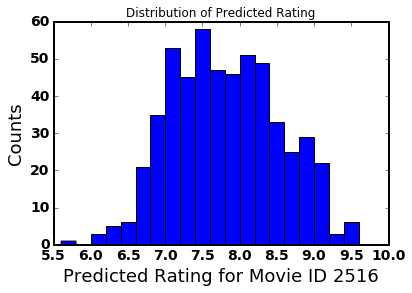

In [228]:
fig, ax = plt.subplots()
snp.labs("Predicted Rating for Movie ID 2516", "Counts", "Distribution of Predicted Rating")
trash = ax.hist(predict_rating, bins=20)

# Error in Nearest Neighbor Voting
Let's see what kind of errors we are getting from this simple $k=5$, Pearson Correlation nearest neighbors approach. We just need to compare the predictions with the actual ratings that these users gave to game ID 2516:

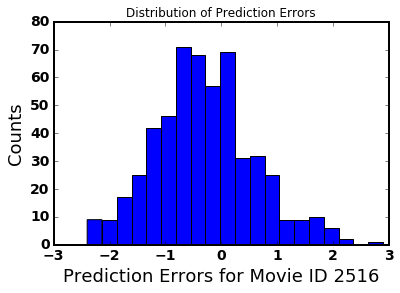

In [233]:
fig, ax = plt.subplots()
snp.labs("Prediction Errors for Movie ID 2516", "Counts", "Distribution of Prediction Errors")
trash = ax.hist(df_pivot.loc[:, 2516].values - predict_rating, bins=20)

More importanly, how does this compare with just predicting this game's average rating? To get a fair comparison we'll round our ratings (and the game's average rating) to the nearest integer, as that is the format for most of the ratings actually given by users.

In [261]:
# Double check that most users are giving integer ratings
sum(df_pivot.loc[:, 2516].values%1 == 0)/len(df_pivot.loc[:, 2516])

0.90520446096654272

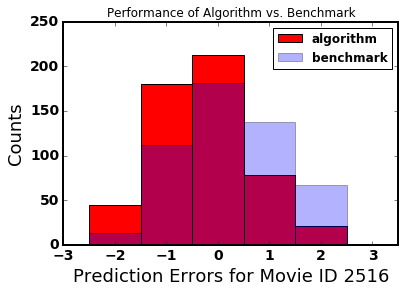

In [264]:
fig, ax = plt.subplots()
snp.labs("Prediction Errors for Movie ID 2516", "Counts", "Performance of Algorithm vs. Benchmark")
bins = np.arange(-3, 4, 1) - 0.5
trash = ax.hist(df_pivot.loc[:, 2516].values - predict_rating.round(), bins=bins, color="red", label="algorithm")
trash = ax.hist(df_pivot.loc[:, 2516].values - round(df_pivot.loc[:, 2516].values.mean()), bins=bins, 
                color="blue", label="benchmark", alpha=0.3)
ax.set_xlim([-3, 3.5])
ax.legend(loc="upper right")

So we're clearly improving upon the naive estimator (always predicting the average movie rating regardless of user), but not by a ton. So lets try modularize this code and start looking at how we can tweak this approach:

# Modularizing Ratings Prediction Code
Lets split this whole workflow into three separate functions to compute similarities from the data for a single game, use those similarities to make predictions of ratings of that game, and then analyze the resulting errors. Our similarity function can implement several different types of similarity to choose from. 

In [229]:
connex = sqlite3.connect("bgg_ratings_recommender_deduplicated.db")  # Opens file if exists, else creates file
sql = "SELECT * FROM data"
df = pd.read_sql_query(sql, connex)
connex.close()

In [230]:
def compute_similarity(gameid, simtype="pearson"):
    """
    Compute the similarity between every pair of users from the set of all users who rated the game 'gameid'.
    """
    
    # Restrict to all users who rated this game and all games rated by this set of users
    users = df.loc[df["gameid"] == gameid, "username"].values  
    df_sample = df[df["username"].isin(users)]  
    
    # Pivot to matrix (user x game) and then get a correlation marix
    df_ratings = df_sample.pivot_table(index="username", columns="gameid", values="ratings") 
    
    if simtype == "pearson":
        sims = df_ratings.transpose().corr(min_periods=4) 
    else:
        print("We didn't recognize that similarity metric.")
        return 0
    
    return sims, df_ratings

In [255]:
def predict_ratings(sims, df_ratings, gameid, k=5):
    """
    Find the k nearest neighbors of a user in terms of the similarities 'sims' and use those users ratings to 
    make a prediction for the rating of the game 'gameid' by each user.
    """
    
    # Identify k nearest neighbors based on similarity
    X = sims.fillna(-1).as_matrix()
    np.fill_diagonal(X, -1)
    k_nearest_indcs = np.argsort(X, axis=1)[:, -k:]  # Return matrix where each row holds index order that would sort that row
    
    # Center the ratings
    user_means = df_ratings.mean(axis=1)
    df_ratings = df_ratings.subtract(df_ratings.mean(axis=1), axis=0)
    
    # Get ratings from the k nearest neighbors of each user
    ratings = df_ratings.as_matrix() 
    neighbor_ratings = np.zeros(k_nearest_indcs.shape)  # Each row holds the ratings from the k nearest neighbors for that user
    this_movie_indx = df_ratings.columns.get_loc(gameid)  # Column int pos'n of movie we are predicting ratings for
    for col, neighbor_indxs in enumerate(k_nearest_indcs.T):
        neighbor_ratings[:,col] = ratings[neighbor_indxs, this_movie_indx]
        
    # Make a prediction based on unweighted average of k nearest neighbors (and "uncenter")
    predicted = user_means + neighbor_ratings.mean(axis=1)  # Average the neighbors ratings and "uncenter"
    
    return predicted

In [250]:
def analyze_errors(df_ratings, predicted, gameid, silent=False):
    """
    Analyze the errors in predictions for game 'gameid', and plot a comparison to the errors from the simplest
    naive estimator of user rating - the games average rating.
    """
    
    # Compute naive estimator - the rounded mean rating of the game
    naive = round(df_ratings.loc[:, gameid].values.mean())
    
    # Compute MSE for our algorithm and for simple estimator
    mse_algo = mean_squared_error(df_ratings.loc[:, gameid].values, predicted)
    mse_naive = mean_squared_error(df_ratings.loc[:, gameid].values, [naive]*len(df_ratings))
    
    # If running silently just return the mean squared errors of algorithm and simple estimator
    if silent:
        return mse_algo, mse_naive
    
    # If not running silently, plot errors
    else:
        fig, ax = plt.subplots()
        snp.labs("Prediction Errors for Movie ID %i" % (gameid,), "Counts", "Performance of Algorithm vs. Benchmark")
        bins = np.arange(-4, 4, 1) - 0.5
        trash = ax.hist(df_ratings.loc[:, gameid].values - predicted.round(), bins=bins, color="red", label="algorithm")
        trash = ax.hist(df_ratings.loc[:, gameid].values - naive, bins=bins, color="blue", label="benchmark", alpha=0.3)
        ax.legend(loc="upper right")

        print("Mean Squared Error of algorithm is %.2f" % (mse_algo,))
        print("Mean Squared Error of naive mean game rating estimator is %.2f" % (mse_naive,))
        return ax, mse_algo, mse_naive

OK lets put all this modularized stuff together now to re-run the analysis for gameid 2516 like we did above.

Mean Squared Error of algorithm is 0.52
Mean Squared Error of naive mean game rating estimator is 1.55
Wall time: 5.46 s


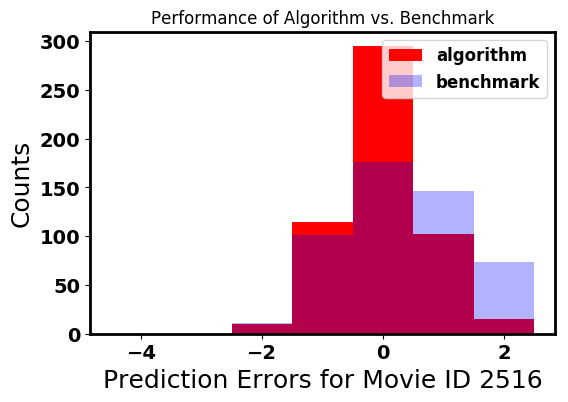

In [258]:
%%time
# Try out our modularized functions!
gameid = 2516
sims, df_ratings = compute_similarity(gameid)
predicted = predict_ratings(sims, df_ratings, gameid, k=20)
analyze_errors(df_ratings, predicted, gameid)

# Effect of k in k-nearest-neighbors

In [256]:
ks = np.arange(1, 300, 1)
mses_basic = [0]*len(ks)
for idx, k in enumerate(ks): 
    predicted_basic = predict_ratings(sims, df_ratings, gameid, k=k)
    mses_basic[idx] = analyze_errors(df_ratings, predicted_basic, gameid, silent=True)[0]

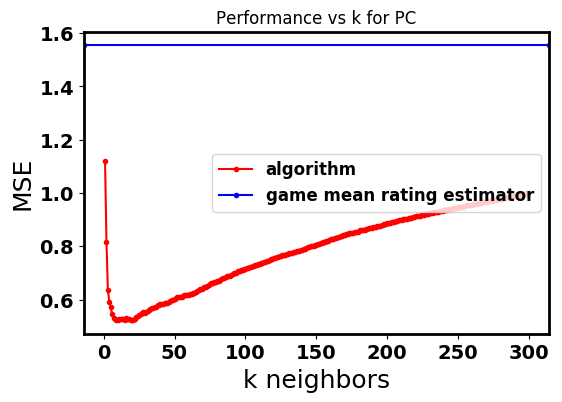

In [257]:
fig, ax = plt.subplots()
snp.labs("k neighbors", "MSE", "Performance vs k for PC")
ax.plot(ks, mses_basic, color="red", label="algorithm")
plt.axhline(analyze_errors(df_ratings, predicted_basic, gameid, silent=True)[1], color="blue", label="game mean rating estimator")
ax.legend(loc="center right")

So it looks like for the simple Pearson correlation $k=25$ is optimal. It's really interesting that even for large number of neighbors we still outperform the naive estimator. Let's start playing with our similarity functions! 

# Implementing Weighted Averaging of Neighbors
Once you've identified the k-nearest neighbors for a user you have the option to incorporate some weighting into the averaging of those neighbors' ratings. That means that among the nearest neighbors of a user, those with the highest correlation have their vote count more in predicting that users rating. Let's try implementing such a weighting, where the weighting is some power of the ratio of a neighbors correlation to the sum of the all the neighbors' correlations. If the set of nearest neighbors is $K$ then we can formalize this as:

\begin{align*}
\textrm{Weighted Average of Neighors Ratings:} \qquad (r_{ai}-\bar{r}_{ai}) \approx \sum_{b\in K} (r_{bi}-\bar{r}_{bi})\times\frac{\textrm{PC}(a,b)^\alpha}{\sum_{b\in K} \textrm{PC}(a,b)^\alpha}
\end{align*}

In [259]:
def predict_ratings(sims, df_ratings, gameid, k=5, weighted_alpha=None):
    """
    Find the k nearest neighbors of a user in terms of the similarities 'sims' and use those users ratings to 
    make a prediction for the rating of the game 'gameid' by each user. The prediction is the (optionally weighted)
    average of the neighbors ratings.
    """
    
    # Identify k nearest neighbors based on similarity
    X = sims.fillna(-1).as_matrix()
    np.fill_diagonal(X, -1)
    k_nearest_indcs = np.argsort(X, axis=1)[:, -k:]  # Return matrix where each row holds index order that would sort that row
    
    # Center the ratings
    user_means = df_ratings.mean(axis=1)
    df_ratings = df_ratings.subtract(df_ratings.mean(axis=1), axis=0)
    
    # Get ratings from the k nearest neighbors of each user
    ratings = df_ratings.as_matrix() 
    neighbor_ratings = np.zeros(k_nearest_indcs.shape)  # Each row holds the ratings from the k nearest neighbors for that user
    for col, neighbor_indxs in enumerate(k_nearest_indcs.T):
        neighbor_ratings[:,col] = ratings[neighbor_indxs, this_movie_indx]

    # Make a prediction, weighted or unweighted, based on average of k nearest neighbors
    if weighted_alpha:
        # Get correlations from the k nearest neighbors of each user
        neighbor_corrs = np.zeros(k_nearest_indcs.shape)
        for row, neighbor_indxs in enumerate(k_nearest_indcs):
            neighbor_corrs[row, :] = X[row, neighbor_indxs]
            amplified = neighbor_corrs**weighted_alpha

        # To divide each row by it's sum requires transposing to get broadcasting to work
        neighbor_weights = (amplified.T/amplified.sum(axis=1).T).T
        predicted = user_means + (neighbor_ratings*neighbor_weights).sum(axis=1)  # Weighted avg k neighbors for each user

    else:        
        predicted = user_means + neighbor_ratings.mean(axis=1)  # Unweighted avg k neighbors for each user
    
    return predicted

(0, 100)

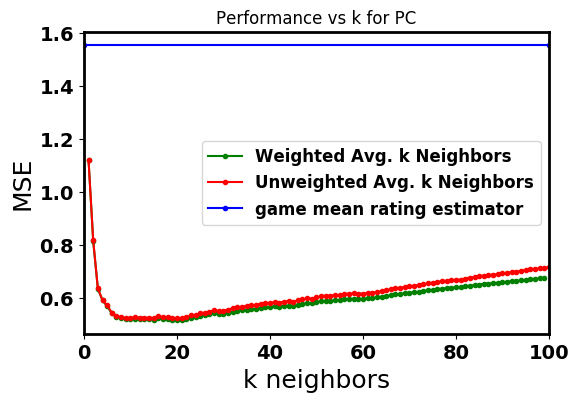

In [260]:
sims, df_ratings = compute_similarity(gameid)

ks = np.arange(1, 100, 1)
mses = [0]*len(ks)
for idx, k in enumerate(ks): 
    predicted = predict_ratings(sims, df_ratings, gameid, k=k, weighted_alpha=1)
    mses[idx] = analyze_errors(df_ratings, predicted, gameid, silent=True)[0]

fig, ax = plt.subplots()
snp.labs("k neighbors", "MSE", "Performance vs k for PC")
ax.plot(ks, mses, color="green", label="Weighted Avg. k Neighbors")
ax.plot(np.arange(1, 300, 1), mses_basic, color="red", label="Unweighted Avg. k Neighbors")
plt.axhline(analyze_errors(df_ratings, predicted_basic, gameid, silent=True)[1], color="blue", label="game mean rating estimator")
ax.legend(loc="center right")
ax.set_xlim([0, 100])

It does seem like weighting improves the error when we are using  large number of neighbors, but doesn't do much otherwise. This is probably because for small number of neighbors all the neighbors have very similar (high) correlations. 

# Implementing Uncertainty-Discounted Pearson Correlation
Just as a reminder, we decided a few sections back that $\beta=30$ might be a reasonable place to start in the uncertainy discounted formula:

\begin{align*}
\textrm{Uncertainty-Discounted Pearson correlation of users $a$ and $b$:} \qquad DPC(a,b) = PC(a,b) \times \frac{\min{\bigl\{|I_{ab}|,\beta\bigr\}}}{\beta} 
\end{align*}

In [261]:
def compute_similarity(gameid, simtype="pearson", beta=20):
    """
    Compute the similarity between every pair of users from the set of all users who rated the game 'gameid'.
    """
    
    # Restrict to all users who rated this game and all games rated by this set of users
    users = df.loc[df["gameid"] == gameid, "username"].values  
    df_sample = df[df["username"].isin(users)]  
    
    # Pivot to matrix (user x game) and then get a correlation marix
    df_ratings = df_sample.pivot_table(index="username", columns="gameid", values="ratings") 
    
    if simtype == "pearson":
        sims = df_ratings.transpose().corr(min_periods=4) 
        
    elif simtype == "uncertainty_discounted_pearson":
        # First compute standard pearson correlation
        sims = df_ratings.transpose().corr(min_periods=4) 
        
        # Make a matrix holding number of common games rated between users (i, j)
        X = df_ratings.as_matrix()  # get values as a numpy matrix
        m1 = (~np.isnan(X)).astype(np.float64)  # zeroes for missing ratings, one elsewhere
        shared = np.dot(m1, m1.T)
        
        # Turn the number of shared games for each user pair into an uncertainty
        uncertainties = np.minimum(shared, beta)/beta
        
        # Multiply uncertainties by pearson correlation
        sims = sims*uncertainties
        
    else:
        print("We didn't recognize that similarity metric.")
        return 0
    
    return sims, df_ratings

In [262]:
%%time
# Compute similarities with new uncertainty weighted pearson correlation
gameid = 2516
sims, df_ratings = compute_similarity(gameid, simtype="uncertainty_discounted_pearson", beta=20)

Wall time: 4.29 s


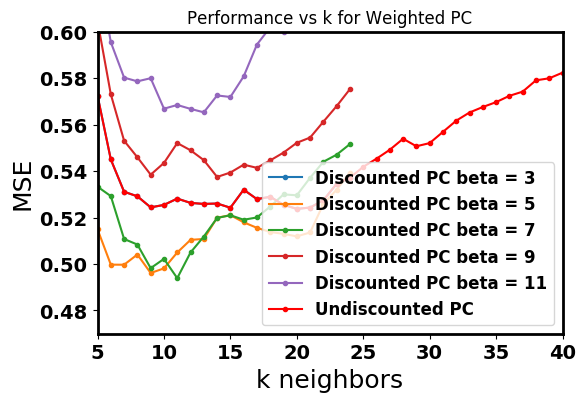

In [270]:
fig, ax = plt.subplots()
snp.labs("k neighbors", "MSE", "Performance vs k for Weighted PC")

# Plot the weighted PCs vs. k for different values of beta
for beta in np.arange(3, 12, 2):
    sims, df_ratings = compute_similarity(gameid, simtype="uncertainty_discounted_pearson", beta=beta)
    ks = np.arange(5, 25, 1)
    mses = [0]*len(ks)
    for idx, k in enumerate(ks):
        predicted = predict_ratings(sims, df_ratings, gameid, k=k)
        mses[idx] = analyze_errors(df_ratings, predicted, gameid, silent=True)[0]   
    ax.plot(ks, mses, label="Discounted PC beta = %i" % (beta,))

# Plot the unweighted PC and naive mean rating estimator vs. k
ax.plot(np.arange(1, 300, 1), mses_basic, color="red", label="Undiscounted PC")
ax.set_xlim([5, 40])
ax.set_ylim([0.47, 0.6])
ax.legend(loc="lower right")

The uncertainty discount really does not seem to improve our performance much - it generally degrades it with perhaps the exception of very small cutoffs (between 3 and 9) that give slight improvements.

The last knob we have to tweak is how much each movie contributes in the calculation of correlation between two users. This is the basis of the weighted Pearson Correlation. Sadly, implementing this means we need to break out the pandas source code to make our own modified version of the `corr` method, so we'll leave that for a post on "advanced" neighborhood methods.

# In Summary
I looked at goodness of downstream ratings predictions as a way to evaluate the underlying similarity metric used in the predictions. Based on the preliminary results, my project that helps boardgamegeek.com users find other similar users to add as buddies should use a discounted Pearson Correlation with a low $\beta$. In a later post I'll implement some more sophisticated approaches to neighborhood methods and run a comparison where the mean squared error is calculated on results across a large number of games. I might also consider implementing this as a custom sklearn estimator.